# Pretrain the GPT2 model

This notebook seeks to replicate Andrey Karpathy's highly popular [nanoGPT](https://github.com/karpathy/nanoGPT/tree/master) project and trains a GPT2 model from scratch using JAX+TPU. Model size is 124M and we train on the [OpenWebText dataset](https://huggingface.co/datasets/Skylion007/openwebtext).

You can run this on Colab, Kaggle or GCP TPUs. As a reference, on Kaggle TPU v3 it takes ~7 hours to finish; Kaggle offers 9 hours of TPUs without interruption, completely free of charge, so you can pretrain a GPT2 model for free.


## Determine platform

In [ ]:
import os
if os.path.exists('/content/'):
  platform = "Colab"
elif os.path.exists('/kaggle/'):
  platform = "Kaggle"
else:
  # Assume using Cloud TPU otherwise
  platform = "GCP"

## Setup

Install JAX and Flax first.

In [ ]:
!pip install -q jax-ai-stack
if platform == "Colab": # temp workaround on Colab (https://github.com/jax-ml/jax-ai-stack/issues/149)
  !pip install -Uq "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
!pip install -Uq tiktoken matplotlib kaggle wandb tpu-info


Confirm we have TPUs set up.

In [ ]:
import jax
jax.devices()

Take care of the imports.

In [ ]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
import optax, orbax
from collections import Counter
from dataclasses import dataclass
from jax.experimental import mesh_utils
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
import numpy as np
import tiktoken, time, wandb

## Build the model

Define the device mesh.


In [ ]:
### Alternative data and model parallel
# mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))

mesh = Mesh(mesh_utils.create_device_mesh((8, 1)), ('batch', 'model'))

We are going to use the GPT-2 tokenizer via OpenAI's [Tiktoken](https://github.com/openai/tiktoken) library.

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

Now define the model architecture. You can refer to [OpenAI's official implementation](https://github.com/openai/gpt-2) or [nanoGPT](https://github.com/karpathy/nanoGPT) for comparison. Main difference is with the sharding scheme.

In [ ]:
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float, rngs: nnx.Rngs):
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                         rngs=rngs)
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                          rngs=rngs)

        self.dropout1 = nnx.Dropout(rate=dropout_rate)  # Added dropout layer after MHA
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P(None, 'model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                         rngs=rngs)
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        self.dropout2 = nnx.Dropout(rate=dropout_rate)

    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        bs, seq_len, emb_sz = input_shape

        attention_output = self.mha(
            inputs_q=self.layer_norm1(inputs),
            mask=causal_attention_mask(seq_len),
            decode=False,
        )
        x = inputs + self.dropout1(attention_output, deterministic=not training)

        # MLP
        mlp_output = self.linear1(self.layer_norm2(x))
        mlp_output = nnx.gelu(mlp_output)
        mlp_output = self.linear2(mlp_output)
        mlp_output = self.dropout2(mlp_output, deterministic=not training)

        return x + mlp_output


class TokenAndPositionEmbedding(nnx.Module):

    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=seqlen, features=embed_dim, rngs=rngs)

    def __call__(self, x):
        positions = jnp.arange(0, x.shape[1])[None, :]
        position_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return self.token_emb, token_embedding+position_embedding


class GPT2(nnx.Module):
    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, num_heads: int, rate: float, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(
                    seqlen, vocab_size, embed_dim, rngs=rngs
                )
        self.dropout = nnx.Dropout(rate=rate)

        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, dropout_rate, rngs=rngs
        ) for _ in range(num_transformer_blocks)]

        self.layer_norm = nnx.LayerNorm(epsilon=1e-6,
                                    num_features=embed_dim,
                                    scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                    bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                    rngs=rngs)

    def __call__(self, inputs, training: bool = False):
        token_embedding, x = self.embedding_layer(inputs)
        x = self.dropout(x, deterministic=not training)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = self.layer_norm(x)
        # Weights tying
        outputs = token_embedding.attend(x)
        return outputs

    @nnx.jit
    def sample_from(self, logits):
        logits, indices = jax.lax.top_k(logits, k=top_k)
        logits = nnx.softmax(logits)
        return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

    @nnx.jit
    def generate_step(self, padded_tokens, sample_index):
        logits = self(padded_tokens)
        next_token = self.sample_from(logits[0][sample_index])
        return next_token

    def generate_text(self, max_tokens, start_tokens, streaming=False):
        generated = []
        for i in range(max_tokens):
            sample_index = len(start_tokens) + len(generated) - 1
            # TODO: use attention masking for better efficiency
            padded_tokens = jnp.array((start_tokens + generated + [50256] * (seqlen - len(start_tokens) - len(generated))))[None, :]
            next_token = int(self.generate_step(padded_tokens, sample_index))
            if streaming == True:
              print(tokenizer.decode([next_token]), end="", flush=True)
            generated.append(next_token)
        if streaming == True:
          print(flush=True)
        return tokenizer.decode(start_tokens + generated)

def create_model(rngs):
    return GPT2(seqlen, vocab_size, embed_dim, num_heads, dropout_rate, feed_forward_dim, num_transformer_blocks, rngs=rngs)

Set some hyperparameters.

In [ ]:
vocab_size = tokenizer.n_vocab
## GPT2 config
num_transformer_blocks = 12
seqlen = 1024
embed_dim = 768
num_heads = 12
feed_forward_dim = 4 * embed_dim

# # GPT2-medium config
# num_transformer_blocks = 24
# seqlen = 1024
# embed_dim = 1024
# num_heads = 16
# feed_forward_dim = 4 * embed_dim
dropout_rate = 0.1
if platform == "Colab":
    batch_size = 24 # TPU v2
else:
    batch_size = 72 # TPU v3  (32 if GPT2-medium)
max_steps = 600000*12//batch_size
init_learning_rate = 5e-4
weight_decay = 1e-1
top_k = 10

Use Weights and Biases to track training progress.

In [ ]:
if platform == "Colab":
  from google.colab import userdata
  os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
  os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
  os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
elif platform == "Kaggle":
  from kaggle_secrets import UserSecretsClient
  user_secrets = UserSecretsClient()
  os.environ['WANDB_API_KEY'] = user_secrets.get_secret('WANDB_API_KEY')
else:
  print("Please set the WANDB_API_KEY env variable manually") #input()

wandb.login()

import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project='GPT2-pretraining',

    # track hyperparameters and run metadata
    config={
    'architecture': 'GPT2',
    'dataset': 'OpenWebText',
    'init_learning_rate': init_learning_rate,
    'num_transformer_blocks': num_transformer_blocks,
    'seqlen': seqlen,
    'embed_dim': embed_dim,
    'num_heads': num_heads,
    'feed_forward_dim': feed_forward_dim,
    'max_steps': max_steps,
    'batch_size': batch_size,
    'weight_decay': weight_decay
    }
)

## Prepare data

Data loading and preprocessing with [Grain](https://github.com/google/grain).

In [ ]:
if platform == "Colab":
  if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
  data_dir = "/content/drive/MyDrive/LLM-pretraining/OpenWebText/" # Assume dataset is already stored there
elif platform == "GCP":
  if not os.path.exists('OpenWebText-gpt2.zip'):
    # Assume kaggle binary is in ~/.local/bin after pip install kaggle
    !~/.local/bin/kaggle datasets download -d windmaple/OpenWebText-gpt2 && unzip OpenWebText-gpt2.zip
  data_dir = "."
elif platform == "Kaggle":  # On Kaggle one should manually add the datasets before running
  data_dir = "/kaggle/input/openwebtext-gpt2"

train_data = np.memmap(os.path.join(data_dir, "train.bin"), dtype=np.uint16, mode="r")
val_data = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint16, mode="r")

# From: https://github.com/karpathy/nanoGPT/blob/9755682b981a45507f6eb9b11eadef8cb83cebd5/train.py#L116
def get_batch(train_or_eval = "train"):

    data = train_data if train_or_eval == "train" else val_data

    ix = np.random.randint(0, len(data) - seqlen, (batch_size,))
    x = np.stack([(data[i:i+seqlen]).astype(np.int64) for i in ix])
    y = np.stack([(data[i+1:i+1+seqlen]).astype(np.int64) for i in ix])

    return x, y

## Train the model

Define loss function and training step function.

In [ ]:
@nnx.jit
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

Create the model and check the model parameter count.

In [ ]:
model = create_model(rngs=nnx.Rngs(0))

def count_params (params) :
    p_tree = jax.tree.map(lambda a: a.size if isinstance(a, jnp.ndarray) else 0, params)
    import operator
    return jax.tree.reduce(operator.add, p_tree)

print(f"Number of model parameters: {count_params(nnx.state(model))}")

Train the model.

In [ ]:
schedule = optax.cosine_decay_schedule(
  init_value=init_learning_rate,
  decay_steps=max_steps
)
optax_chain = optax.chain(
  optax.adamw(learning_rate=schedule, weight_decay=weight_decay)
)
optimizer = nnx.Optimizer(model, optax_chain)

train_metrics = nnx.metrics.Average('loss')
val_metrics = nnx.metrics.Average('val_loss')

rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:seqlen]
print(f"Inital generated text:\n{start_prompt}", end="")
generated_text = model.generate_text(
    seqlen//10, start_tokens
)

metrics_history = {
  'train_loss': [],
  'val_loss': []
}

step = 0
start_time = time.time()
while True:
    input_batch, target_batch = get_batch("train")
    if len(input_batch) % len(jax.devices()) != 0: continue  # skip the remaining elements
    train_step(model, optimizer, train_metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

    if (step + 1) % 200 == 0:
      train_loss = float(train_metrics.compute())
      metrics_history['train_loss'].append(train_loss)

      elapsed_time = time.time() - start_time
      print(f"Step {step + 1}, Training loss: {train_loss}, Elapsed Time: {elapsed_time:.2f} seconds")

      # eval step
      input_val_batch, target_val_batch = get_batch('val')
      loss, logits = loss_fn(model, jax.device_put((input_val_batch, target_val_batch), NamedSharding(mesh, P('batch', None))))
      val_metrics.update(val_loss=loss, logits=logits)
      val_loss = float(val_metrics.compute())
      metrics_history['val_loss'].append(val_loss)
      wandb.log(data={'val_loss': val_loss, 'train_loss': train_loss}, step=step)
      print(f"Step {step + 1}, Validation Loss: {val_loss}")
      train_metrics.reset()
      val_metrics.reset()

      start_time = time.time()
    step += 1

    if step > max_steps:
      break

# Final text generation
print(f"Final generated text:\n{start_prompt}", end="")
generated_text = model.generate_text(
    seqlen//10, start_tokens
)

Visualize the training loss.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

As you can see, the model goes from generating completely random words at the beginning to generating sensible sentences at the end of the training.

Final train loss is 3.09 and val loss is 3.04. In comparison, nanoGPT 124M GPT2 achieves final train loss 3.11 and val loss 3.12 ([link](https://wandb.ai/windmaple/GPT2-pretraining?nw=nwuserwindmaple)).

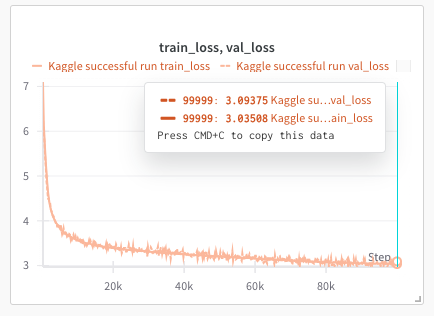

# Model saving

In [ ]:
import orbax.checkpoint as orbax
import shutil

if platform == "Colab":
  checkpoint_path = "/content/checkpoints"
elif platform == "Kaggle":
  checkpoint_path = "/kaggle/working/checkpoints"
else:
  from pathlib import Path
  home = Path.home()
  checkpoint_path = os.path.join(str(home), "checkpoints")

# make sure the folder is empty and usable
shutil.rmtree(checkpoint_path, ignore_errors=True)

checkpointer = orbax.PyTreeCheckpointer()
train_state = nnx.state(model)
checkpointer.save(checkpoint_path, train_state)

# Model restoration
Restore the model checkpoint. A pretrained checkpoint is also available [here](https://www.kaggle.com/models/windmaple/gpt2/).

In [ ]:
model = nnx.eval_shape(lambda: create_model(rngs=nnx.Rngs(0)))
state = nnx.state(model)
checkpointer = orbax.PyTreeCheckpointer()
state = checkpointer.restore(checkpoint_path, item=state)
nnx.update(model, state)

generated_text = model.generate_text(
    seqlen//10, start_tokens
)
print(f"Restored model generated text:\n{generated_text}")

# Disconnect the Colab runtime

In [ ]:
if platform == "Colab":
  from google.colab import runtime
  runtime.unassign()